## Кейсы, которые могут встретися в работе
* Изменилась схема JSON, парсим старым скрипптом 
* Перестал работать источник внешних данных 
* Ошибка в коде для насчета признака 
* Выкатили новый продукт (резкий скачок конверсии)
* Поменялось распределение признаков 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
description = pd.read_csv('HomeCredit_columns_description.csv', encoding_errors='ignore', index_col='Row',)

In [ ]:
description.head()

Unnamed: 0                         Table  \
Row                                                            
SK_ID_CURR                   1  application_{train|test}.csv   
TARGET                       2  application_{train|test}.csv   
NAME_CONTRACT_TYPE           5  application_{train|test}.csv   
CODE_GENDER                  6  application_{train|test}.csv   
FLAG_OWN_CAR                 7  application_{train|test}.csv   

                                                          Description Special  
Row                                                                            
SK_ID_CURR                                   ID of loan in our sample     NaN  
TARGET              Target variable (1 - client with payment diffi...     NaN  
NAME_CONTRACT_TYPE        Identification if loan is cash or revolving     NaN  
CODE_GENDER                                      Gender of the client     NaN  
FLAG_OWN_CAR                            Flag if the client owns a car     NaN

In [ ]:
application_train_df = pd.read_csv('application_train.csv')
print('Training data shape: ', application_train_df.shape)

Training data shape:  (307511, 122)


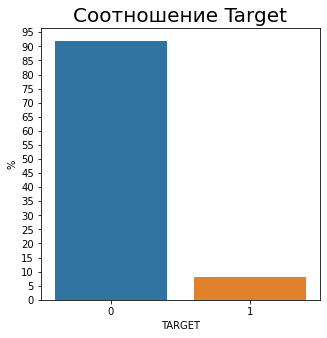

index    percent
0      0  91.927118
1      1   8.072882

In [ ]:
norm_target = (application_train_df
               .TARGET
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())
plt.figure(figsize=(5, 5))
ax = sns.barplot(x='index', y='percent', data=norm_target)
plt.title('Соотношение Target', fontsize=20)
plt.xlabel('TARGET', fontsize=10)
plt.ylabel('%', fontsize=10);
plt.yticks(np.arange(0, 100, step=5))
plt.show()
norm_target

### Удаление выбросов
Значения признака, выбивающиейся из общей массы.

Причины:
* Ошибка в сборе данных или неправильно заполненные NaN (нежелательное явление)
* Реальное, но редкое значение (может быть полезной информацией, например для антифрода)

Почему важно обратить внимание:
* Неправильное значение = неправильное предсказание.
* Влияет на среднее значение, некоторые алогритмы чувствительны к выбросам (линейные модели).

### Линейная модель

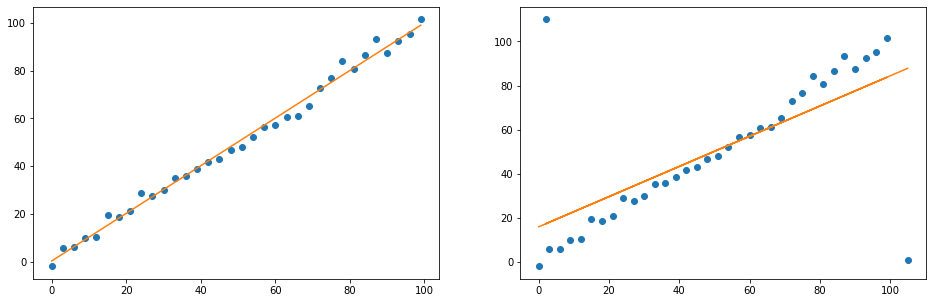

In [ ]:
x = [i for i in range(0,100,3)]
y =  [i + np.random.normal(0,3)  for i in range(0,100,3)] 
fig,ax = plt.subplots(nrows=1, ncols=2,figsize=(16,5))
plt.subplot(121)
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*np.array(x) + b)
x = x + [2, 105]
y =y + [110, 1]
plt.subplot(122)
plt.plot(x, y, 'o')
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*np.array(x) + b)
plt.show()

#### Рассмотрим признак OWN_CAR_AGE

In [ ]:
description.loc['OWN_CAR_AGE']['Description']

"Age of client's car"

In [ ]:
application_train_df['OWN_CAR_AGE'].describe()

count    104582.000000
mean         12.061091
std          11.944812
min           0.000000
25%           5.000000
50%           9.000000
75%          15.000000
max          91.000000
Name: OWN_CAR_AGE, dtype: float64

## Boxplot 

![Boxplot](maxresdefault.jpg)

<AxesSubplot:xlabel='OWN_CAR_AGE'>

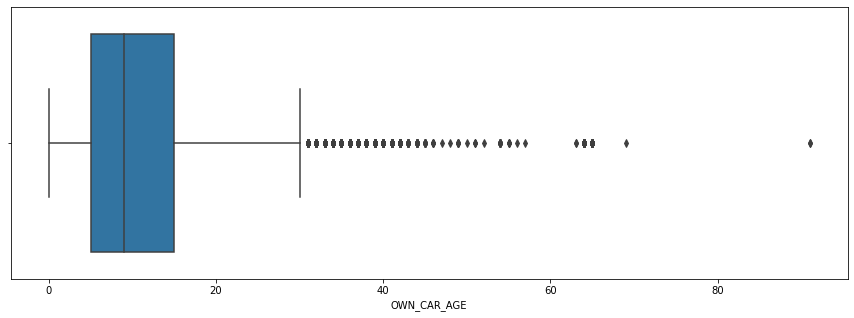

In [ ]:
plt.figure(figsize=(15, 5))
sns.boxplot(x=application_train_df['OWN_CAR_AGE'])

In [ ]:
def get_outliers_info(df, d = 1.5):
    """
    Статистика по наличию выбросов в признаках.
    df - датасет с признаками 
    d - коэффициент, на который умножается IQR (обычно 1.5, что соотв. усам на boxplot)
    """
    df = df.copy()
    q75 = df.quantile(0.75)
    q25 = df.quantile(0.25)
    iqr = q75 - q25

    feature_list, outlier_list = [], []
    numerical_columns = [c for c in df.columns if df[c].dtype in ['float64', 'int64'] and df[c].nunique()>10]

    for feature in numerical_columns:
        lower_threshold = q25.loc[feature] - d*iqr[feature]
        upper_threshold = q75.loc[feature] + d*iqr[feature]
        
        df['is_outlier'] = np.nan
        df.loc[(df[feature] < lower_threshold) | (df[feature] > upper_threshold), 'is_outlier'] = 1
        df['is_outlier'] = df['is_outlier'].fillna(0)

        feature_list.append(feature)
        outlier_list.append(df['is_outlier'].mean())
        
    outliers_df = pd.DataFrame(index=feature_list, data=outlier_list, columns=['ratio_outliers'])
    outliers_df = outliers_df[outliers_df['ratio_outliers']>0]
    outliers_df = outliers_df.sort_values(by='ratio_outliers', ascending=False)
    
    return outliers_df

In [ ]:
outliers_df = get_outliers_info(application_train_df)

In [ ]:
outliers_df.head(10)

ratio_outliers
DAYS_EMPLOYED                    0.234844
AMT_REQ_CREDIT_BUREAU_QRT        0.164466
AMT_REQ_CREDIT_BUREAU_MON        0.142301
OBS_30_CNT_SOCIAL_CIRCLE         0.064944
OBS_60_CNT_SOCIAL_CIRCLE         0.063620
NONLIVINGAREA_MODE               0.061191
NONLIVINGAREA_MEDI               0.056109
NONLIVINGAREA_AVG                0.053806
NONLIVINGAPARTMENTS_AVG          0.050665
NONLIVINGAPARTMENTS_MEDI         0.049478

## Что делать с выбросами:

Если это ошибка в сборе данных или неправильно заполненный NaN:
* Заменить на NaN (и далее разбираться с ними).
* Удалить 

Если это реальное значение:
* Удалить
* Использовать алгоритмы, не чувствительные к выборосам (на базе деревьев).
* Использовать clip (все значения вне указанного интервала заменяются на концы интервала). 
* Трансформировать значения признаков с помощью функции (например логарифм).

# Рассмотрим признак OWN_CAR_AGE:
### Немножко поменяем датасет
<!-- * Нет NaN 
* Положительные значения признака не имеют смысла, так как стаж считается как дата получения займа - дата начала работы на текущем месте.

Скорее всего, это заполненные NaN и стоит заменить их обратно на NaN.  -->

In [ ]:
application_train_df['car_model_name'] = np.nan

In [ ]:
import random
car_list = ["Tesla", "ГАЗ M20", np.nan]

In [ ]:
application_train_df.loc[application_train_df.FLAG_OWN_CAR=='Y','car_model_name'] = random.choices(car_list, k=104587)

- Ошибка в данных (Мало) -> Удалить 
- Реальные значения (Мало) -> Удалить


In [ ]:
application_train_df[
    (application_train_df.OWN_CAR_AGE > 50)
    &(application_train_df.OWN_CAR_AGE < 60)
][['car_model_name','OWN_CAR_AGE']].value_counts().sort_index()

car_model_name  OWN_CAR_AGE
Tesla           54.0           6
                55.0           2
                57.0           1
ГАЗ M20         54.0           2
                55.0           1
dtype: int64

- Ошибка в данных (Много) -> Разбираться (Например заполнить NaN)
- Реальные значения (Много) -> Разбираться (Например заполнить NaN)

In [ ]:
application_train_df[
    application_train_df.OWN_CAR_AGE > 60
][['car_model_name','OWN_CAR_AGE']].value_counts().sort_index()

car_model_name  OWN_CAR_AGE
Tesla           63.0             1
                64.0           814
                65.0           300
ГАЗ M20         63.0             1
                64.0           847
                65.0           297
                69.0             1
                91.0             2
dtype: int64

## Resample

In [ ]:
import datetime as dt

start_date = dt.datetime(year=2021, month=12, day=1)
end_date = dt.datetime(year=2022, month=3, day=10)

dates = pd.date_range(
    start_date,
    end_date
).strftime('%m/%d/%Y').tolist()

In [ ]:
sales1 = pd.DataFrame()
sales1['date'] =dates
sales2 = pd.DataFrame()
sales2['date'] =dates
sales1['date'] = pd.to_datetime(sales1['date'])
sales2['date'] = pd.to_datetime(sales2['date'])
sales3 = pd.read_csv('sales3.csv')
sales3['date'] = pd.to_datetime(sales3['date'])


In [ ]:
sales_before = [random.randint(200, 300) for i in range(89)]
sales_after = [random.randint(10, 50) for i in range(11)]
sales1['count'] = sales_before + sales_after
sales_2 = [random.randint(200, 300) for i in range(100)]
sales2['count'] = sales_2

In [ ]:
sales2.loc[
    (sales2.date >= '2022-02-01')
    & (sales2.date < '2022-02-05'),'count'
] = [random.randint(1, 50) for i in range(4)]

In [ ]:
sales2.head()

date  count
0 2021-12-01    221
1 2021-12-02    258
2 2021-12-03    281
3 2021-12-04    267
4 2021-12-05    228

<AxesSubplot:xlabel='count'>

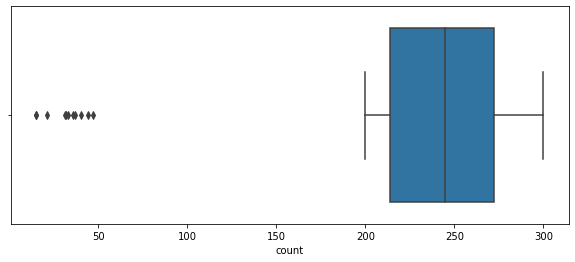

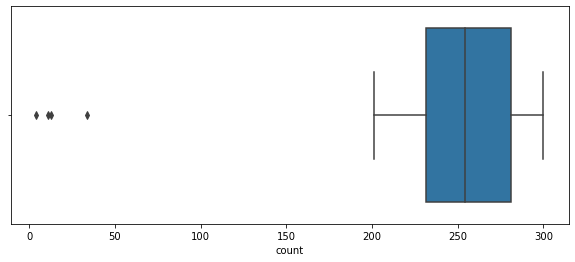

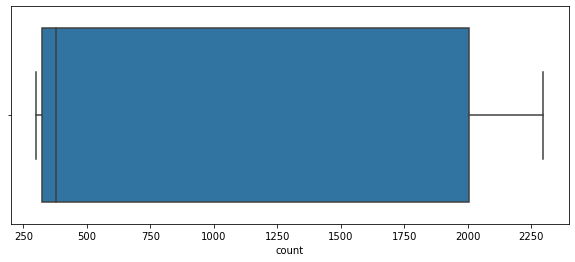

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=sales1['count'])
plt.figure(figsize=(10, 4))
sns.boxplot(x=sales2['count'])
plt.figure(figsize=(10, 4))
sns.boxplot(x=sales3['count'])

<AxesSubplot:xlabel='date'>

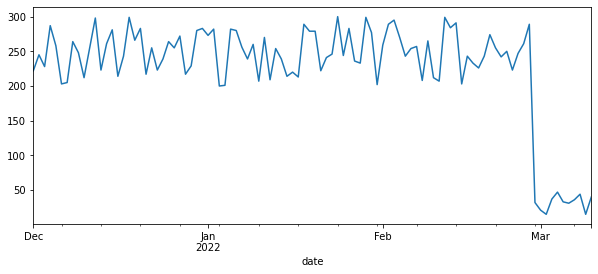

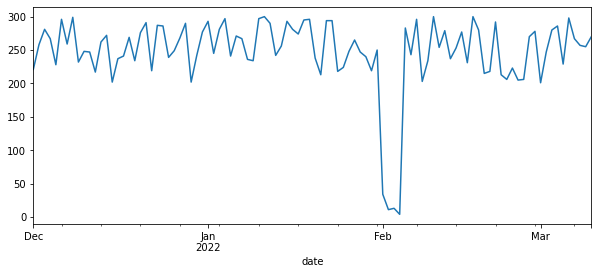

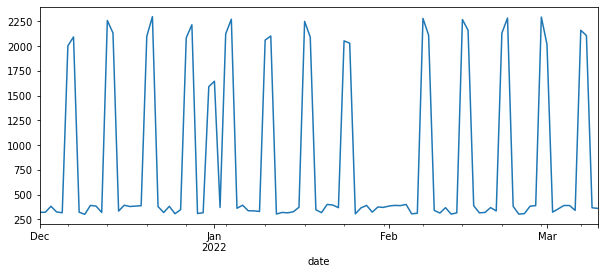

In [ ]:
plt.figure(figsize=(10, 4))
sales1.resample('1d', on='date')['count'].mean().plot()
plt.figure(figsize=(10, 4))
sales2.resample('1d', on='date')['count'].mean().plot()
plt.figure(figsize=(10, 4))
sales3.resample('1d', on='date')['count'].mean().plot()

# Заполнение пропусков
Причины:
* Ошибка в сборе данных (нежелательное явление)
* Отсутствие информации (например возраст машины для тех, у кого нет машины) 

Почему важно обратить на это внимание:
* Может быть период, когда данные не поступают, и мы имеем пропуски в каком-либо признаке. Если таргет меняется во времени, то модель выучит, что пропуск влияет на таргет даже если это не так.


In [ ]:
def get_nan_info(df):
    """
    Статистика по наличию пропусков в признаках.
    df - датасет с признаками
    """
    df = df.copy()  
    nans_df = pd.DataFrame(df.isnull().sum().rename('n_nans'))
    
    N = df.shape[0]
    nans_df['ratio_nans'] = nans_df['n_nans']/N
    nans_df['ratio_nans'] = nans_df['ratio_nans'].round(2)
    
    nans_df = nans_df[nans_df['n_nans']>0]
    nans_df = nans_df.sort_values(by='n_nans', ascending=False)
    
    for feature in nans_df.index:
        nans_df.loc[feature, 'nan_target_mean'] = df[df[feature].isnull()]['TARGET'].mean()
        nans_df.loc[feature, 'not_nan_target_mean'] = df[df[feature].notnull()]['TARGET'].mean()
        
    return nans_df 

In [ ]:
nans_df = get_nan_info(application_train_df)

In [ ]:
nans_df.head(10)

n_nans  ratio_nans  nan_target_mean  \
car_model_name            237869        0.77         0.083134   
COMMONAREA_MEDI           214865        0.70         0.085742   
COMMONAREA_MODE           214865        0.70         0.085742   
COMMONAREA_AVG            214865        0.70         0.085742   
NONLIVINGAPARTMENTS_MODE  213514        0.69         0.085835   
NONLIVINGAPARTMENTS_MEDI  213514        0.69         0.085835   
NONLIVINGAPARTMENTS_AVG   213514        0.69         0.085835   
FONDKAPREMONT_MODE        210295        0.68         0.086188   
LIVINGAPARTMENTS_MEDI     210199        0.68         0.086214   
LIVINGAPARTMENTS_MODE     210199        0.68         0.086214   

                          not_nan_target_mean  
car_model_name                       0.072514  
COMMONAREA_MEDI                      0.069102  
COMMONAREA_MODE                      0.069102  
COMMONAREA_AVG                       0.069102  
NONLIVINGAPARTMENTS_MODE             0.069130  
NONLIVINGAPARTMENTS_MEDI             0.069130  
NONLIVINGAPARTMENTS_AVG              0.069130  
FONDKAPREMONT_MODE                   0.068919  
LIVINGAPARTMENTS_MEDI                0.068882  
LIVINGAPARTMENTS_MODE                0.068882

In [ ]:
description.loc['DAYS_EMPLOYED']['Description']

'How many days before the application the person started current employment'

In [ ]:
application_train_df.loc[application_train_df['DAYS_EMPLOYED']>0, 'DAYS_EMPLOYED'] = np.nan

In [ ]:
application_train_df['DAYS_EMPLOYED'].isnull().sum()

55374

In [ ]:
application_train_df[
    application_train_df['DAYS_EMPLOYED'].isnull()
]['NAME_INCOME_TYPE'].value_counts()

Pensioner     55352
Unemployed       22
Name: NAME_INCOME_TYPE, dtype: int64

In [ ]:
application_train_df.loc[
    (application_train_df['NAME_INCOME_TYPE'] == 'Unemployed') &
    (application_train_df.DAYS_EMPLOYED.isnull()), 'DAYS_EMPLOYED'
]= 0

In [ ]:
application_train_df.groupby(['NAME_INCOME_TYPE'])['TARGET'].mean()

NAME_INCOME_TYPE
Businessman             0.000000
Commercial associate    0.074843
Maternity leave         0.400000
Pensioner               0.053864
State servant           0.057550
Student                 0.000000
Unemployed              0.363636
Working                 0.095885
Name: TARGET, dtype: float64

Итого:
* Средняя дефолтность пенсионеров - 5.3%, это ниже средней. 
* Чтобы не запутывать интерпретацию признака DAYS_EMPLOYED, заполним NaN значением, которое не будет влиять на мнение модели. Возьмем медиану, так как распределение далеко от нормального.

In [ ]:
DAYS_EMPLOYED_median = application_train_df[application_train_df['DAYS_EMPLOYED'].notnull()]['DAYS_EMPLOYED'].median()
print(DAYS_EMPLOYED_median)
application_train_df['DAYS_EMPLOYED'] = application_train_df['DAYS_EMPLOYED'].fillna(DAYS_EMPLOYED_median)

-1647.0


#### Медиана группы

In [ ]:
sales3['count'].median()

378.5

In [ ]:
sales3.groupby('day')['count'].median()

day
Воскресенье    2109.0
Вторник         319.0
Понедельник     339.0
Пятница         343.5
Среда           381.0
Суббота        2128.0
Четверг         351.5
Name: count, dtype: float64

## Сбой на стороне

In [ ]:
train_df = pd.read_csv('application_train.csv')


In [ ]:
train_df['date'] = random.choices(dates, k=train_df.shape[0])
train_df['date'] = pd.to_datetime(train_df['date'])

In [ ]:
train_df['bki_score'] = ([random.random() for i in range(application_train_df.shape[0] - 50000)] 
                                     + [np.nan for i in range(50000)])

In [ ]:
train_df_2 = train_df.copy()

In [ ]:
train_df_2.loc[
    (train_df_2.date > '2022-02-25'),'bki_score'
] = train_df.bki_score.apply(lambda x: random.choice([np.nan,x]))

In [ ]:
train_df.loc[
    (train_df.date > '2022-02-10') &
    (train_df.date < '2022-02-15'),'bki_score'
] = np.nan

In [ ]:
get_nan_info(train_df[['bki_score','TARGET']])

n_nans  ratio_nans  nan_target_mean  not_nan_target_mean
bki_score   60463         0.2         0.079139             0.081118

In [ ]:
get_nan_info(train_df_2[['bki_score','TARGET']])

n_nans  ratio_nans  nan_target_mean  not_nan_target_mean
bki_score   66600        0.22          0.08003             0.080922

<AxesSubplot:xlabel='date'>

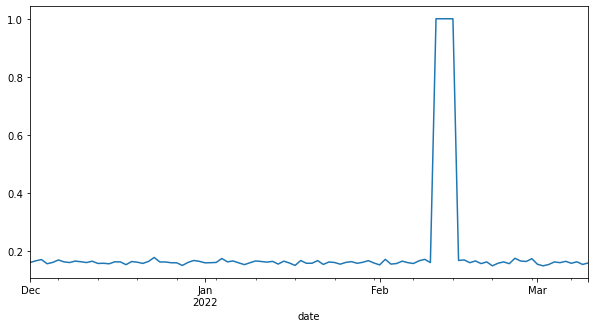

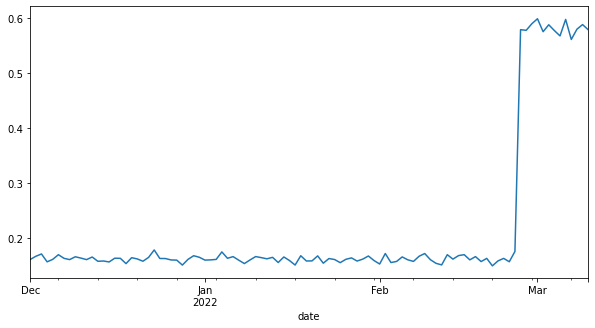

In [ ]:
plt.figure(figsize=(10, 5))
(train_df[
    train_df['bki_score'].isnull()
].resample('1d', on='date').size()/ train_df.resample('1d', on='date').size()).plot()
plt.figure(figsize=(10, 5))
(train_df_2[
    train_df_2['bki_score'].isnull()
].resample('1d', on='date').size()/ train_df_2.resample('1d', on='date').size()).plot()

## Способы заполнения пропусков:

Ошибки в сборе данных:
* Удалить
* Среднее/медиана/мода
* Обучить модель, которая предсказывает значение пропуска на основе значений остальных признаков.
* Заполнение предыдущим значением или интерполяция. Работает в случаях, когда одна и та же информация собирается с человека несколько раз (например, список установленных приложений).

Отсутствие информации:
* Если нет признака feature_1, который помечает NaN в признаке feature_2, то стоит добавить такой бинарный признак. Например для признака "возраст машины" нужен признак "наличие машины". Тогда "наличие машины" = 0 будет соответствовать NaN в признаке "возраст машины".</br>
* Далее NaN можно заполнить таким значением, которое не влияет на мнение модели. (среднее/медиана/мода)

### Категориальные признаки

Что делать с категориальными признаками:
* Некоторые алогритмы умеют работать с категориальными признаками (catboost, lightgbm), возможно стоит использовать именно такие алгоритмы.
* LabelEncoding
* OneHotEncoding
* TargetEncoding


In [ ]:
# Найдем все категориальные признаки
categorical_columns = [c for c in application_train_df.columns if application_train_df[c].dtype in ['object']]
print(categorical_columns)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'car_model_name']


In [ ]:
# Заполним пропуски самыми простым способом: наиболее частотной категорией
for col in categorical_columns:
    mode = application_train_df[col].mode().iloc[0]
    application_train_df[col] = application_train_df[col].fillna(mode)

#### Label Encoding

Плюсы:
* Не увеличивает число признаков.

Минусы:
* Числовые значения в итоговом признаке неупорядочены.

Можно использовать для моделей на основе деревьев.

In [ ]:
# Обучим энкодер
categorical_features_le = pd.DataFrame()
for col in categorical_columns:
    le = LabelEncoder()
    application_train_df[f'{col}_le'] = le.fit_transform(application_train_df[col])

In [ ]:
application_train_df.groupby('NAME_EDUCATION_TYPE_le')['TARGET'].mean()

NAME_EDUCATION_TYPE_le
0    0.018293
1    0.053551
2    0.084850
3    0.109277
4    0.089399
Name: TARGET, dtype: float64

In [ ]:
# Для признаков, категории которых поддаются сравнению, можно бороться с этой проблемой с помощью OrdinalEncoder, но порядок придется задавать самому
oe = OrdinalEncoder(categories = [['Lower secondary','Secondary / secondary special', 'Incomplete higher', 'Higher education','Academic degree']])
application_train_df['NAME_EDUCATION_TYPE_oe'] = oe.fit_transform(application_train_df[['NAME_EDUCATION_TYPE']])

In [ ]:
application_train_df.groupby('NAME_EDUCATION_TYPE_oe')['TARGET'].mean()

NAME_EDUCATION_TYPE_oe
0.0    0.109277
1.0    0.089399
2.0    0.084850
3.0    0.053551
4.0    0.018293
Name: TARGET, dtype: float64

#### One Hot Encoding

Плюсы:
* Влияние каждой категории рассматривается по-отдельности.

Минусы: 
* Если много категорий, то число признаков сильно увеличивается.

Можно использоваться для линейных моделей.

In [ ]:
# Обучим энкодер
enc = OneHotEncoder(sparse=False)
categorical_features_enc = enc.fit_transform(application_train_df[categorical_columns])
categorical_features_enc = pd.DataFrame(data=categorical_features_enc, columns=enc.get_feature_names(categorical_columns))

In [ ]:
categorical_features_enc.head()

NAME_CONTRACT_TYPE_Cash loans  NAME_CONTRACT_TYPE_Revolving loans  \
0                            1.0                                 0.0   
1                            1.0                                 0.0   
2                            0.0                                 1.0   
3                            1.0                                 0.0   
4                            1.0                                 0.0   

   CODE_GENDER_F  CODE_GENDER_M  CODE_GENDER_XNA  FLAG_OWN_CAR_N  \
0            0.0            1.0              0.0             1.0   
1            1.0            0.0              0.0             1.0   
2            0.0            1.0              0.0             0.0   
3            1.0            0.0              0.0             1.0   
4            0.0            1.0              0.0             1.0   

   FLAG_OWN_CAR_Y  FLAG_OWN_REALTY_N  FLAG_OWN_REALTY_Y  \
0             0.0                0.0                1.0   
1             0.0                1.0                0.0   
2             1.0                0.0                1.0   
3             0.0                0.0                1.0   
4             0.0                0.0                1.0   

   NAME_TYPE_SUITE_Children  NAME_TYPE_SUITE_Family  \
0                       0.0                     0.0   
1                       0.0                     1.0   
2                       0.0                     0.0   
3                       0.0                     0.0   
4                       0.0                     0.0   

   NAME_TYPE_SUITE_Group of people  NAME_TYPE_SUITE_Other_A  \
0                              0.0                      0.0   
1                              0.0                      0.0   
2                              0.0                      0.0   
3                              0.0                      0.0   
4                              0.0                      0.0   

   NAME_TYPE_SUITE_Other_B  NAME_TYPE_SUITE_Spouse, partner  \
0                      0.0                              0.0   
1                      0.0                              0.0   
2                      0.0                              0.0   
3                      0.0                              0.0   
4                      0.0                              0.0   

   NAME_TYPE_SUITE_Unaccompanied  NAME_INCOME_TYPE_Businessman  \
0                            1.0                           0.0   
1                            0.0                           0.0   
2                            1.0                           0.0   
3                            1.0                           0.0   
4                            1.0                           0.0   

   NAME_INCOME_TYPE_Commercial associate  NAME_INCOME_TYPE_Maternity leave  \
0                                    0.0                               0.0   
1                                    0.0                               0.0   
2                                    0.0                               0.0   
3                                    0.0                               0.0   
4                                    0.0                               0.0   

   NAME_INCOME_TYPE_Pensioner  NAME_INCOME_TYPE_State servant  \
0                         0.0                             0.0   
1                         0.0                             1.0   
2                         0.0                             0.0   
3                         0.0                             0.0   
4                         0.0                             0.0   

   NAME_INCOME_TYPE_Student  NAME_INCOME_TYPE_Unemployed  \
0                       0.0                          0.0   
1                       0.0                          0.0   
2                       0.0                          0.0   
3                       0.0                          0.0   
4                       0.0                          0.0   

   NAME_INCOME_TYPE_Working  NAME_EDUCATION_TYPE_Academic degree  \
0                       1.0    

#### Target Encoding
Плюсы:
* Не увеличивает число признаков.

Минусы:
* Возможен оверфит! Лучше обучать энкодер на данных, которые не используются ни для тренировки ни для валидации.

Можно использовать для любых моделей.

In [ ]:
# Посмотрим, как таргет зависит от образования заемщика
application_train_df.groupby('NAME_EDUCATION_TYPE')['TARGET'].mean()

NAME_EDUCATION_TYPE
Academic degree                  0.018293
Higher education                 0.053551
Incomplete higher                0.084850
Lower secondary                  0.109277
Secondary / secondary special    0.089399
Name: TARGET, dtype: float64

In [ ]:
# Для простоты обучим энкодер на всей тренировочной выборке
te = TargetEncoder()
application_train_df_te = te.fit_transform(
    application_train_df[categorical_columns],
    application_train_df['TARGET']
).add_suffix('_te')

In [ ]:
# Проверим результат
pd.concat([application_train_df['NAME_EDUCATION_TYPE'], application_train_df_te['NAME_EDUCATION_TYPE_te']], axis=1)

NAME_EDUCATION_TYPE  NAME_EDUCATION_TYPE_te
0       Secondary / secondary special                0.089399
1                    Higher education                0.053551
2       Secondary / secondary special                0.089399
3       Secondary / secondary special                0.089399
4       Secondary / secondary special                0.089399
...                               ...                     ...
307506  Secondary / secondary special                0.089399
307507  Secondary / secondary special                0.089399
307508               Higher education                0.053551
307509  Secondary / secondary special                0.089399
307510               Higher education                0.053551

[307511 rows x 2 columns]

# Домашнее задание

## Дано:
* Датафрейм с 3 признаками : (status, income, age)
* status: (Student, Pensioneer, Working, Businessman)
* income - доход в месяц
* age - возраст

## Нужно сделать:
* Провести разведочный анализ: describe(), кол-во пропусков, выбросов, построить boxplot и тп.
* Заполнить(удалить) пропуски, заменить(удалить) выбросы, кратко аргументировать замены. 
* Получить датафрейм с качественными данными

### Ноутбук с кодом выкладываем в GitLab

In [ ]:
homework = pd.read_csv('HomeWork.csv', index_col=0)

In [ ]:
homework.sort_values('date')